<a href="https://colab.research.google.com/github/ayaka-honda/lesson_ai/blob/master/Titanic(0_78468).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic: Machine Learning from Disaster
### Modeling achieved 78.4% accuracy


使用した説明変数　：　'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked'

使用したアルゴリズム　：　SVM

ハイパーパラメータ : gamma=0.1,C=1

In [0]:
# 必要なモジュールのインポート
import pandas as pd
import numpy as np
from numpy.random import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
sns.set()
%precision 3
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC,SVC

In [15]:
# データ読込と項目の確認
data_original=pd.read_csv('train.csv')
data=data_original.copy()

test_original=pd.read_csv('test.csv')
test=test_original.copy()

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# trainデータ数とオブジェクトタイプの確認
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# trainデータの欠損値を確認
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# testデータの欠損値を確認
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [6]:
# 相関係数の確認
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [7]:
# 生存者の特徴を確認
data.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


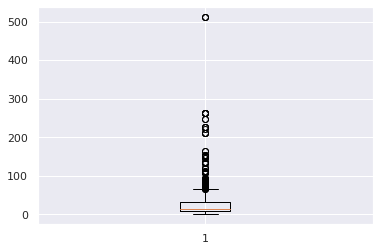

In [8]:
# 'Fare'の分布を確認
plt.boxplot(data['Fare'])
plt.show()

###考察
*   ’Pclass’と'Fare' は'Survived'との相関が比較的高いが、お互いの相関も高いので多重共線性に注意
*   'Age'と'Survived'の相関が予想に反して低い
*   'Fare'はばらつきが大きい

In [9]:
# クラスごとの特徴を確認
data.groupby('Pclass').mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


###考察
'Pclass'ごとに平均年齢が異なる

## Trainデータ前処理

*   'Age'の欠損をクラス別の値で補完

*   'Embarked'が欠損の行を削除

## Testデータ前処理

*   'Age'の欠損をクラス別の値で補完

In [0]:
# クラス別のデータを変数に代入
data_class1= data[data['Pclass']==1]
data_class2= data[data['Pclass']==2]
data_class3= data[data['Pclass']==3]

In [0]:
# クラスごとの'Age'の平均値で欠損を補完
def age(x):
  if x==1:
    return data['Age'].fillna(data_class1['Age'].mean(), inplace=True)
  elif x==2:
    return data['Age'].fillna(data_class2['Age'].mean(), inplace=True)
  else:
    return data['Age'].fillna(data_class3['Age'].mean(), inplace=True)
for i in data['Pclass']:
  age(i)

In [25]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [0]:
# 使用しない特徴量を削除
data.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], axis=1, inplace=True)

In [27]:
# 'Embarked'の欠損を削除
data.dropna(inplace=True)
data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

In [28]:
# 説明変数と目的変数の設定
y=data['Survived']
X= data.drop('Survived', axis=1)
# 説明変数の量的データをダミー化
X_dummies=pd.get_dummies(X)
X_dummies

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.00000,1,0,0,1,0,0,1
1,1,38.00000,1,0,1,0,1,0,0
2,3,26.00000,0,0,1,0,0,0,1
3,1,35.00000,1,0,1,0,0,0,1
4,3,35.00000,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
886,2,27.00000,0,0,0,1,0,0,1
887,1,19.00000,0,0,1,0,0,0,1
888,3,25.14062,1,2,1,0,0,0,1
889,1,26.00000,0,0,0,1,1,0,0


In [0]:
# テストデータ前処理
test_class1= test[test['Pclass']==1]
test_class2= test[test['Pclass']==2]
test_class3= test[test['Pclass']==3]

def age(x):
  if x==1:
    return test['Age'].fillna(test_class1['Age'].mean(), inplace=True)
  elif x==2:
    return test['Age'].fillna(test_class2['Age'].mean(), inplace=True)
  else:
    return test['Age'].fillna(test_class3['Age'].mean(), inplace=True)
for i in test['Pclass']:
  age(i)

In [0]:
# 説明変数を設定
test.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], axis=1, inplace=True)

In [33]:
test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

In [34]:
# 説明変数の量的データをダミー化
X_test_dummies=pd.get_dummies(test)
X_test_dummies

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.500000,0,0,0,1,0,1,0
1,3,47.000000,1,0,1,0,0,0,1
2,2,62.000000,0,0,0,1,0,1,0
3,3,27.000000,0,0,0,1,0,0,1
4,3,22.000000,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
413,3,24.027945,0,0,0,1,0,0,1
414,1,39.000000,0,0,1,0,1,0,0
415,3,38.500000,0,0,0,1,0,0,1
416,3,24.027945,0,0,0,1,0,0,1


In [35]:
# ハイパーパラメータの設定
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, stratify=y, test_size=0.3, random_state=0)

# Standarlized
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

scores={}
for gamma in np.logspace(-3, 2, num=6):
  for C in np.logspace(-3, 2, num=6):
    model=SVC(gamma=gamma, C=C)
    model.fit(X_train_std, y_train)
    scores[(gamma, C)]=model.score(X_test_std, y_test)


scores=pd.Series(scores)
print('Best score:{:.3f}'.format(scores.max()))
print('paramaters(gamma,C):{}'.format(scores.idxmax()))

Best score:0.850
paramaters(gamma,C):(0.1, 1.0)


In [36]:
model=SVC(gamma=0.1,C=1,random_state=0)
model.fit(X_train_std, y_train)


print('score(train):{}'.format(model.score(X_train_std, y_train)))
print('score(test):{}'.format(model.score(X_test_std, y_test)))

score(train):0.8311897106109325
score(test):0.850187265917603


In [0]:
# テストデータの標準化
sc = StandardScaler()
sc.fit(X_test_dummies)
X_std = sc.transform(X_test_dummies)
predict = model.predict(X_std)

In [0]:
test_original['Survived']=predict
test_result=test_original[['PassengerId','Survived']]
test_result.set_index('PassengerId', inplace=True)
test_result

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


In [0]:
test_result.to_csv('titanic_result.csv')